In [1]:
%cd ..

/root/autobound/autobounds-main


In [52]:
from autobound.causalProblem import causalProblem
from autobound.DAG import DAG
from autobound.Query import Query
import io
from copy import deepcopy

import networkx as nx
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Introduction

This notebook introduces `autobounds` (Duarte et al., 2023), a package for drawing principled inferences in the presence of common imperfections in data and design. Section 1 will introduce data from a randomized controlled trial with noncompliance, the context that will be used to demonstrate key package functionality. Section 2 states the causal effects of interest to the analyst and discusses various assumptions that analysts might use for identification. Section 3 walksthrough the computation of the causal effects of interest demonstrating the key package functionality in parallel. 

# Section 1: Data

In the city-village *DoesNotExist* three Scholars carried out a randomized controlled trial with the aim of determining the causal effect of the (binary) treatment $X$ on the (binary) outcome $Y$. The trial contained 1000 subjects. After collecting all of their data, the researchers found that there was reason to believe that some subjects in the were **noncompliant** with their assignment treatment regimen. This indicates the presence of a confounding influence between the treatment and the outcome. In an attempt to salvage the computation of the causal effect, the Scholars justify that the (binary) instrument $Z$ can be said to *encourage* the taking of treatment, and thus proceed under an instrumental variables strategy. 

We first present some initial exploratory analysis of the data.

In [4]:
raw_iv_dat = pd.read_csv("autobounds_demo/raw_iv_synth.csv")

In [5]:
raw_iv_dat.head()

,Z,X,Y
0,1,0,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


In [6]:
# check structure of data frame
raw_iv_dat.info()

# is binary?
print(raw_iv_dat["Z"].unique()) 
print(raw_iv_dat["X"].unique())
print(raw_iv_dat["Y"].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Z       1000 non-null   int64
 1   X       1000 non-null   int64
 2   Y       1000 non-null   int64
dtypes: int64(3)
memory usage: 23.6 KB
[1 0]
[0 1]
[1 0]


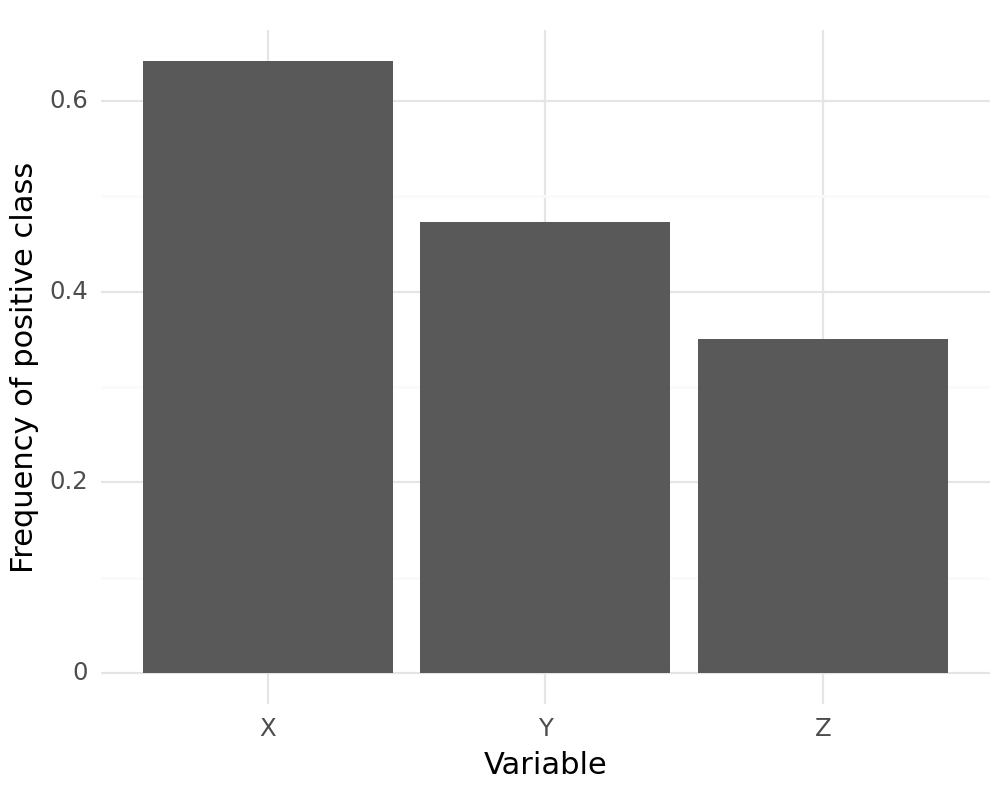

<Figure Size: (500 x 400)>

In [27]:
# raw proportions
raw_props = raw_iv_dat.agg(np.mean).to_frame().reset_index().rename(columns={'index':'var', 0:'prop'})

pn.options.figure_size = (5, 4)
(
pn.ggplot(raw_props, pn.aes(x='var', y='prop')) 
    + pn.geom_bar(stat='identity') 
    + pn.xlab("Variable")    
    + pn.ylab("Frequency of positive class")
    + pn.theme_minimal()
)

That is, 35% of subjects were encouraged to take treatment, 64% received the treatment and 47% experienced the positive outcome.

In [9]:
# check for a nonzero correlation

x_z1 = raw_iv_dat.X.loc[raw_iv_dat.Z == 1]
x_z0 = raw_iv_dat.X.loc[raw_iv_dat.Z == 0]

pr_x1_z1 = (x_z1 == 1).sum() * 1.0 / x_z1.shape[0]
pr_x1_z0 = (x_z0 == 1).sum() * 1.0 / x_z0.shape[0]

print("              Pr[X=1|Z=1] = {:>4.1f}%".format(pr_x1_z1 * 100))
print("              Pr[X=1|Z=0] = {:>4.1f}%".format(pr_x1_z0 * 100))
print("Pr[X=1|Z=1] − Pr[X=1|Z=0] = {:>4.1f}%".format((pr_x1_z1 - pr_x1_z0) * 100))

              Pr[X=1|Z=1] = 25.4%
              Pr[X=1|Z=0] = 85.1%
Pr[X=1|Z=1] − Pr[X=1|Z=0] = -59.6%


The Scholars of this study would be wrong to conclude that $Z$ influences the taking of treatment if it were uncorrelated with $X$ (treatment assignment). Here we find that there is a quite noticeable association between the instrument and treatment assignment. 

In [51]:
# contingency table
ct = pd.crosstab([raw_iv_dat.Z, raw_iv_dat.X], raw_iv_dat.Y, margins=True)
ct
#ct_sm = sm.stats.Table(ct) # further analysis

Y        0    1   All
Z   X                
0   0   66   31    97
    1  377  176   553
1   0   63  198   261
    1   21   68    89
All    527  473  1000

In [10]:
# some logistic regressions for some intuition
mod1 = smf.logit("X ~ Z", data=raw_iv_dat).fit()
print(mod1.summary()) # model summary

odds_ratios1 = pd.DataFrame(
    {
        "OR": mod1.params,
        "Lower CI": mod1.conf_int()[0],
        "Upper CI": mod1.conf_int()[1],
    }
)
odds_ratios1 = np.exp(odds_ratios1) # effect interpretation

print(odds_ratios1)

Optimization terminated successfully.
         Current function value: 0.472340
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      X   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Aug 2023   Pseudo R-squ.:                  0.2758
Time:                        18:22:50   Log-Likelihood:                -472.34
converged:                       True   LL-Null:                       -652.26
Covariance Type:            nonrobust   LLR p-value:                 3.055e-80
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7406      0.110     15.813      0.000       1.525       1.956
Z             -2.8165      0.

We perform a logistic regression on the variables in the study to just get some intuition on what the data tells us about the relationships between these variables. Indeed, here, we see that experiencing the effect of the instrument $Z=1$ means that an individual's odds of taking treatment decrease by 94%.

In [11]:
mod2 = smf.logit("Y ~ X", data=raw_iv_dat).fit()
print("++++ Summary ++++")
print(mod2.summary()) # model summary

odds_ratios2 = pd.DataFrame(
    {
        "OR": mod2.params,
        "Lower CI": mod2.conf_int()[0],
        "Upper CI": mod2.conf_int()[1],
    }
)
odds_ratios2 = np.exp(odds_ratios2) # effect interpretation

print("++++ Odds ratios ++++")
print(odds_ratios2)

Optimization terminated successfully.
         Current function value: 0.660341
         Iterations 4
++++ Summary ++++
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Aug 2023   Pseudo R-squ.:                 0.04532
Time:                        18:22:51   Log-Likelihood:                -660.34
converged:                       True   LL-Null:                       -691.69
Covariance Type:            nonrobust   LLR p-value:                 2.414e-15
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5739      0.110      5.213      0.000       0.358       0.790
X          

Here, an individuals odds of experiencing the positive outcome decrease by 65% by taking treatment. While there is a negative associational relationship between treatment and outcome, of course, this is not sufficient to identify any sort of causal effect.

# Section 2: Identification of causal effects

In the absence of selection on observable covariates -- i.e. we depart from the (conditional) randomised experiment setting, leaving the average treatment effect (ATE) unidentified -- a popular identification strategy is via the use of instrumental variables. Here, an 'instrument' is a device that the researcher can justify to _encourage_ quasi-random treatment assignment, consequently, one can identify a local average treatment effect of the treatment on the outcome.

Let the treatment be $X$, the outcome $Y$ and the instrument $Z$. We will generally write $Y(x)$ to denote a counterfactual outcome of the variable $Y$ under the intervention $X=x$. Assume that all variables are binary, that is their support is the set $\{0,1\}$. An instrument must obey the following criteria:

* (Unconfoundedness) $Z$ is independent of $Y(x)$ for any $x \in \{0,1\}$
* (Relevance) $Z$ is correlated with $x$, that is, $\textrm{Corr}(D,Z) \ne 0$, i.e. the instrument influecnes the treatment.
* (Exclusion restriction) $Y(z,x) = Y(x)$ for all $x, z \in \{0,1\}$. That is, $Z$ may only influence $Y$ through $X$.

To point identify the local average treatment effect (LATE) -- the treatment effect in one behavioral subgroup of the population -- it is well known that more conditions are necessary. One sufficiently strong condition is the monotonicity, or "no defiers", assumption. That is

* (Monotonicity) $X(z=1) \ge X(z=0).$

The population of interest can unambiguously be divided into four mutually exclusive behavioral groups:

* Compliers: $(X(z=1)=1, X(z=0)=0)$
* Defiers: $(X(z=1)=0, X(z=0)=1)$
* Always-takers: $(X(z=1)=1, X(z=0)=1)$
* Never-takers: $(X(z=1)=0, X(z=0)=0)$

Therefore, we can offer some intuition behind the monotonicity assumption (according to James Robins) as follows: we can only estimate the effect of treatment on those whose behavior was actually affected by the instrument, thus, Compliers and Defiers are the only relevant subgroups of the population for the computation of the LATE. To have both is problematic, therefore, if we only consider compliers our results follow nicely.

Under monotonicity, it is indeed possible to identify the average treatment effect in the compliers. However, this raises some important issues:

* Are the compliers the only subset of the population of interest -- what recommendations do we make to the other strata of individuals?
* The compliers are not observable (they are defined by counterfactual variables) so we cannot target the intervention to them.
* Hernan and Robins argue that interest in this estimand is often not due to its practical relevance, but its ease of identifiability. For this reason, research inquirires are perhaps weaker or retrofitted to extract a point estimate from the data: this is undesirable.

Autobounds alleviates this issue by pursuing a _question-driven_ approach. The scholar will state their research question, their target estimand, and all relevant assumptions on the data as demanded by the context of the problem. If the estimand is not point identifiable in this setting, Autobounds provides informative bounds on the (partially identified) causal effect without the need to alter the original purpose of the research.

It has been shown in the literature that in the IV setting, sharp bounds on the ATE are attainable with a linear-programming approach even when monotonicity is not assumed. Autobounds generalises this approach by not only calculating bounds for the ATE, but for nonlinear quantities such as the LATE and beyond. We will demonstrate the use of Autobounds in Python below.

---

We will illustrate how autobounds functions via three distinct data generating mechanisms which represent three differing sets of assumptions on the causal mechanism at play. 

Three researchers, Scholars Cautious, Just and Confident, have determined that there unmeasured confounding, encapsulated by the _disturbance_ $U_{DY}$, exists between the treatment $D$ and the outcome $Y$ and hence selection on observables is not a valid approach to identification. The scholars instead decide to approach via the use of instruments. We will demonstrate stepwise how to use the `autobounds` package, and how it is informed by the theory, to compute bounds on the ATE under the assumptions these three scholars individually impose.

# Section 3: Computation of effects via `autobounds`

## 3.1 The ATE

### 3.1.1 Scholar Just

* Scholar Just believes that the causal mechanism sits well in the canoncial framework of an instrumental variables design. All three conditions of the instrument as stated earlier are satisfied. The corresponding causal graph is illustrated below.

In the autobounds package, it is straightforward to create the (causal) directed acyclic graph for the autobounds problem. Instatiate an empty DAG via the `DAG` class within the package. Build the structure of the graph with the method `from_structure` which takes two arguments: `edges` and `unob`.

Indeed, `edges` takes a string of all paths of length two separated by commas. Similarly, `unob` takes all disturbances as a string with the variables separated by commas.

One can then visualise the graph with the `plot` method.

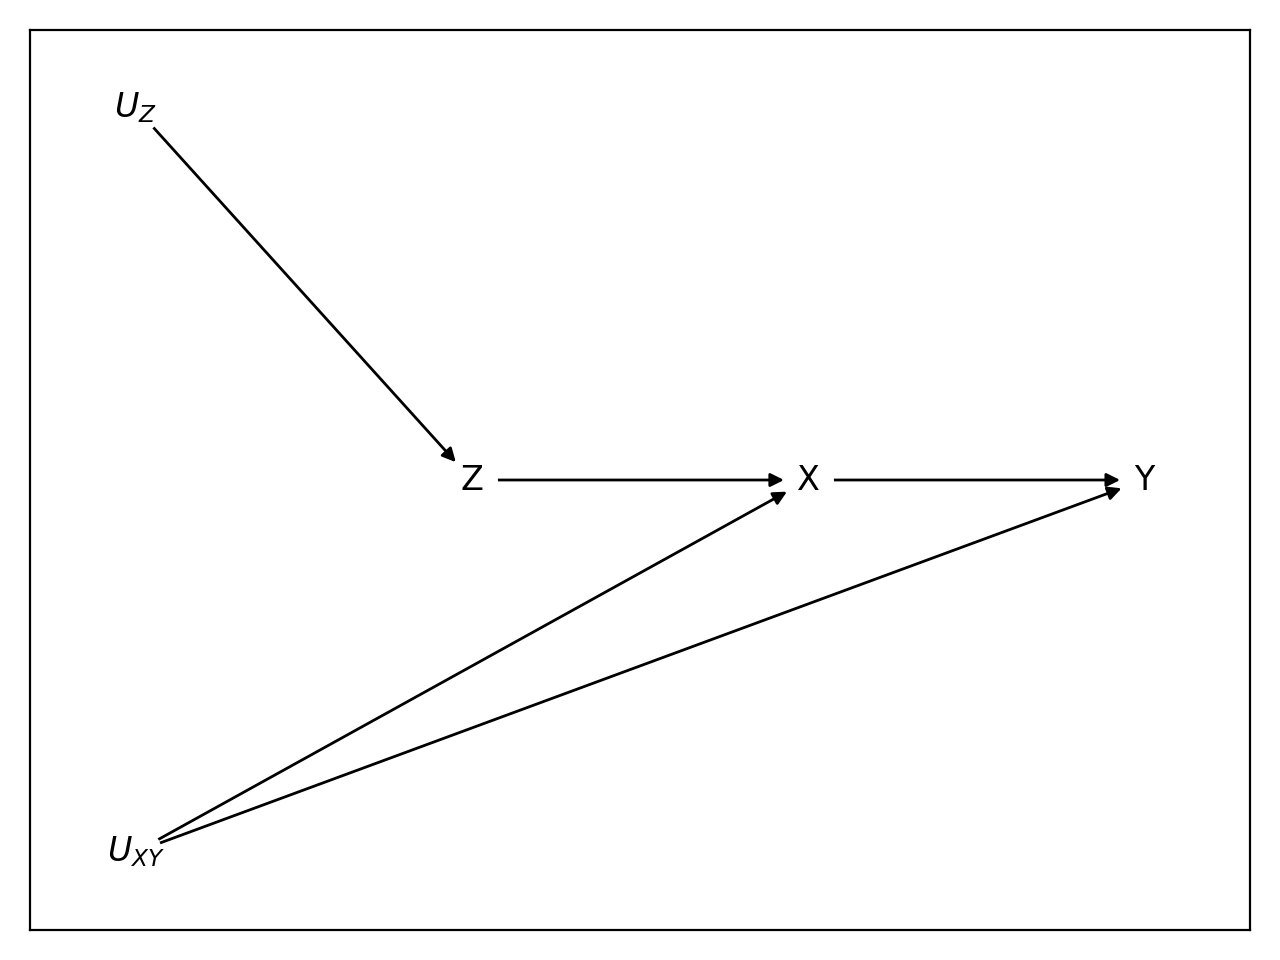

In [54]:
dag_just = DAG()
dag_just.from_structure(edges="Uz -> Z, Z -> X, X -> Y, Uxy -> X, Uxy -> Y", unob = "Uz, Uxy")

dag_just.plot()

$\newcommand{\Pro}{\mathbb{P}}$
$\newcommand{\Puz}{\Pro(U_Z = u_Z)}$
$\newcommand{\Puxy}{\Pro(U_{XY} = u_{XY})}$
$\newcommand{\uin}[1]{u_{#1} \in S(U_{#1})}$


Autobounds now aims to solve an polynomial optimisation problem, made simpler by adding in constraints on the parameters to be optimised over. We will have constraints defined by the axioms of probability, $\mathcal{P}$, empirical evidence, $\mathcal{E}$ and assumptions imposed by the researcher $\mathcal{A}.$

The parameters over which we optimise the objective function are generated by the disturbances in the causal graph. Our assumed causal mechansim gives the following structural equations for $(Z, X, Y)$ and the types of observable response.

\begin{align}
&\underline{\text{Structural Eq.}} && &\underline{\text{Response Func.}} && &\underline{\text{Response Form}} \\
Z &= f_Z(U_Z) && &f_Z^{(U_Z=u_Z)}(\varnothing) && &\varnothing \mapsto \{0,1\} \\
X &= f_X(Z, U_{XY}) && &f_X^{(U_{XY} = u_{XY})}(z) && &\{0,1\} \mapsto \{0,1\} \\
Y &= f_Y(X, U_{XY}) && &f_Y^{(U_{XY} = u_{XY})}(x) && &\{0,1\} \mapsto \{0,1\} 
\end{align}
where the response functions $f_{(\cdot)}$ are determininstic functions of their arguments, and $f_{(\cdot)}^{(U=u)}$ is $f_{(\cdot)}$ under a fixed realisation $u$ of the disturbance $U$. We assume all disturbances are independent. The response form illustrates all possible mappings of the response function. The disturbances encapsulate all which in the universe of our problem set up, deterministically affect $(Z,X,Y)$, producing all possible factual and counterfactual outcomes. The symbol $\varnothing$ is used to indicate that if the only parents of a variable in the DAG are disturbances, in effect, any realisation of this variable is spawned by unobservable phenomena.

From this construction, we observe that since $Z$ is binary, irrespective of its dimensionality, $U_Z$ can only induce either $Z=0$ or $Z=1$ upon any realisation. In this way, we can unambiguously decompose $U_Z$ into what we call its canonical partition, $S(U_Z)$, i.e.

\begin{equation}
S(U_Z) = \left\{u_Z : f_Z^{(U_Z=u_Z)}(\varnothing) = 0\right\} \cup \left\{u_Z : f_Z^{(U_Z=u_Z)}(\varnothing) = 1\right\}.
\end{equation}

Consequently, we can treat $U_z$ as a **categorical variable** with support $S(U_Z).$ The size of this partition/support in this case is $2$. 

As $U_{XY}$ jointly determines the response functions $f_X$ and $f_Y$, we can decompose $U_{XY}$ into a canonical partition of size $16$, $S(U_{XY})$. Indeed: since $X$ has only $Z$ as an observable parent in the graph, $U_{XY}$ can induce four behavioural groups (compliers, always-takers, ...) in $X$, and similarly for $Y$. Hence, we observe $4 \times 4 = 16$ joint responses for $(X,Y)$, i.e. strata such as $\{X$-never, $Y$-always$\}$ and so on.

These $18$ disturbance values form the parameters of our problem, i.e. the categorical laws $\Pro(U_Z = u_Z)$ for $u_Z \in S(U_Z)$ and $\Pro(U_{XY} = u_{XY})$ for $u_{XY} \in S(U_{XY})$. They are in one to one correspondence with the numbers $\Pro(Z=z)\, \forall z$ and $\Pro(X$-type$, Y$-type'$)$ for type $\in \{$always, never, comply, defy$\}$.

In this way, we can write down the axiomatic or **Kolmogorov** constraints, $\mathcal{C}_\mathcal{P}$, as 

\begin{align}
\mathcal{C}_\mathcal{P} = 
\Big\{\Puz \ge 0, \Puxy \ge 0, \; \text{for all} \; \uin{Z}, \uin{XY}\Big\}
  \cap
  \left\{\sum_{\uin{Z}} \Puz = \sum_{\uin{XY}} \Puxy = 1\right\}
\end{align}

These conditions simply state that the unobservable disturbances are categorical probability distributions over their corresponding supports, in particular, they are nonnegative and sum to unity. 

Remark: some parameters might be eliminated from the optimisation because of redundancies implied by the laws of probability.

Now, let us note that our parameters (i.e. $P(U=u)$) are further limited by the empirical data collected in the study. This is intuitive because the causal effect we determine should be informed by the empirical evidence of the study at hand. Indeed, in this problem, the data collected gives us $8$ empirical probabilities corresponding to the $8$ possible strata of our population. These (joint) probabilities take the form $\Pro(Z=z, X=x, Y=y)$. We can compute them as follows, the column `prob` houses these probabilities.

In [56]:
# group individuals into strata
dat = pd.DataFrame(raw_iv_dat.groupby(['Z', 'X', 'Y']).value_counts().reset_index()) 
dat['prob'] = dat['count'] / dat['count'].sum()
dat = dat.drop(columns='count', axis=0)
dat

,Z,X,Y,prob
0,0,0,0,0.066
1,0,0,1,0.031
2,0,1,0,0.377
3,0,1,1,0.176
4,1,0,0,0.063
5,1,0,1,0.198
6,1,1,0,0.021
7,1,1,1,0.068


We now express these probabilities in terms of the parameters above: 
\begin{equation}
\Pro(Z=z, X=x, Y=y) = \sum_{u_Z, u_{XY} \in \overline{U}} \Puz \Puxy 
\end{equation}
where
\begin{equation}
\overline{U} = \left\{\uin{Z}, \uin{XY} : f_Z^{(U_Z = u_Z)}(\varnothing) = z, f_X^{(U_{XY} = u_{XY})}(z) = x, f_Y^{(U_{XY} = u_{XY})}(z) = y\right\} 
\end{equation}
That is, the likelihood of jointly observing $(Z=z, X=x, Y=y)$ is equal to the joint likelihood of the disturbance relations which yield $(Z=z, X=x, Y=y)$ being realised. Recall that we assume here that disturbances are statistically independent. **note about canonical DAGs?

This relationship forms the empirical constraints $\mathcal{C}_\mathcal{E}$.

Both $\mathcal{C}_\mathcal{P}$ and $\mathcal{C}_\mathcal{E}$ are simple to implement in the `autobounds` package.

--- 
Firstly, instantiate the causal problem with the corresponding causal DAG and load in the summary of observed frequencies of observed population strata. The `load_data` method can take either a filepath or a pandas dataframe, however it must have the structure of the dataframe `dat` computed above.  

In [13]:
problem_just = causalProblem(dag_just)
problem_just.load_data(dat)

Encode the Kolmogorov and empirical constraints into the problem, informed by the observed frequencies as above.

In [14]:
problem_just.add_prob_constraints()

$\newcommand{\E}{\mathbb{E}}$
Define the estimand of interest: here we seek the average treatment effect i.e.
\begin{equation}
\tau = \E[Y(x=1)] - \E[Y(x=0)] = \Pro(Y(x=1)=1) - \Pro(Y(x=0)=1),
\end{equation}
since $Y$ is binary. We may write this in the parameters of our problem as follows (as this estimand does not depend on the disturbance $U_Z$)
\begin{equation}
\tau = \sum_{u_{XY} \in U_1} \Puxy - \sum_{u_{XY} \in U_0} \Puxy
\end{equation}
where
\begin{equation}
U_a = \left\{\uin{XY}: f_Y^{(U_{XY} = u_{XY})}(x=a) = 1\right\}
\end{equation}

for each $a \in \{0,1\}$. We may use the `set_ate` method of the `causalProblem` class to define the ATE. Its first argument, `ind`, takes the treatment variable, while its second argument, `dep`, takes the outcome of interest. This method also contains a third argument, `cond`, which is the conditioning set of the ATE; in this case, we consider the whole population of individuals so this argument is left as defualt. 

In [15]:
problem_just.set_ate(ind="X", dep="Y")

Remark that the researcher has posed no additional assumptions on the data than those of the causal graph, and so the constraint set $\mathcal{C}_\mathcal{A}$ is empty. Further remark that all constraint sets, $\mathcal{C}_\mathcal{E}$ and $\mathcal{C}_\mathcal{P}$, and the effect of interest $\tau$ are polynomials in the parameters defined by the disturbances. 

With that in hand, now Autobounds will solve the optimisation problems
\begin{equation}
\text{min}\; \tau \; \text{subject to} \; \mathcal{C}_\mathcal{E} \cap \mathcal{C}_\mathcal{P}
\end{equation}
and
\begin{equation}
\text{max}\; \tau \; \text{subject to} \; \mathcal{C}_\mathcal{E} \cap \mathcal{C}_\mathcal{P}.
\end{equation}

In python, we first write the polynomial program using the method `write_program`. We then apply the method `run_scip` which will solve the optimisation problem stated above.

In [16]:
problem_just_ate = problem_just.write_program()
problem_just_ate.run_scip('replication_files/results/iv_ate_cautious.csv') # run optimisation routine, argument saves results at filename

LOWER BOUND: # -- Primal: -0.5492337 / Dual: -0.5494856 / Time: * 0.0 ##
UPPER BOUND: # -- Primal: -0.1457116 / Dual: -0.1453633 / Time: * 0.0 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 0.40412230000000005 / Epsilon: 0.0014874030443436936 ##


({'primal': -0.549233663179677,
  'dual': -0.549233663179677,
  'time': 0.03,
  'end': 1},
 {'primal': -0.145711606421906,
  'dual': -0.145711606421906,
  'time': 0.04,
  'end': 1},
 0.40352205675777103,
 0.0)

Thus we find that the average treatment effect $\tau \in [-0.549, -0.147]$. Scholar Just can conlude with confidence that there is a causal effect of $X$ on $Y$.

**Intuition for $\varepsilon$ and $\theta$**?

### 3.1.2 Scholar Cautious

* Scholar Cautious is very conservative their assumptions on the causal mechanism; they do not have faith in the exclusion restriction criterion on the instrument, which is reflected by the $Z \rightarrow Y$ path on the graph below.

Scholar Cautious and Scholar Just differ in their approaches to this causal analysis in only one way. Scholar Cautious' additional conservatism has led to a change in the DAG that is appropriate for the study. Therefore, we proceed in `autobounds` much like Scholar Just, except that we add another path to the DAG at the beginning of the problem. We remark that the additional path $Z \rightarrow Y$ reflects that Scholar Cautious does not have faith in the assumption that the instrument satisfies the *exclusion restriction* property of an IV.

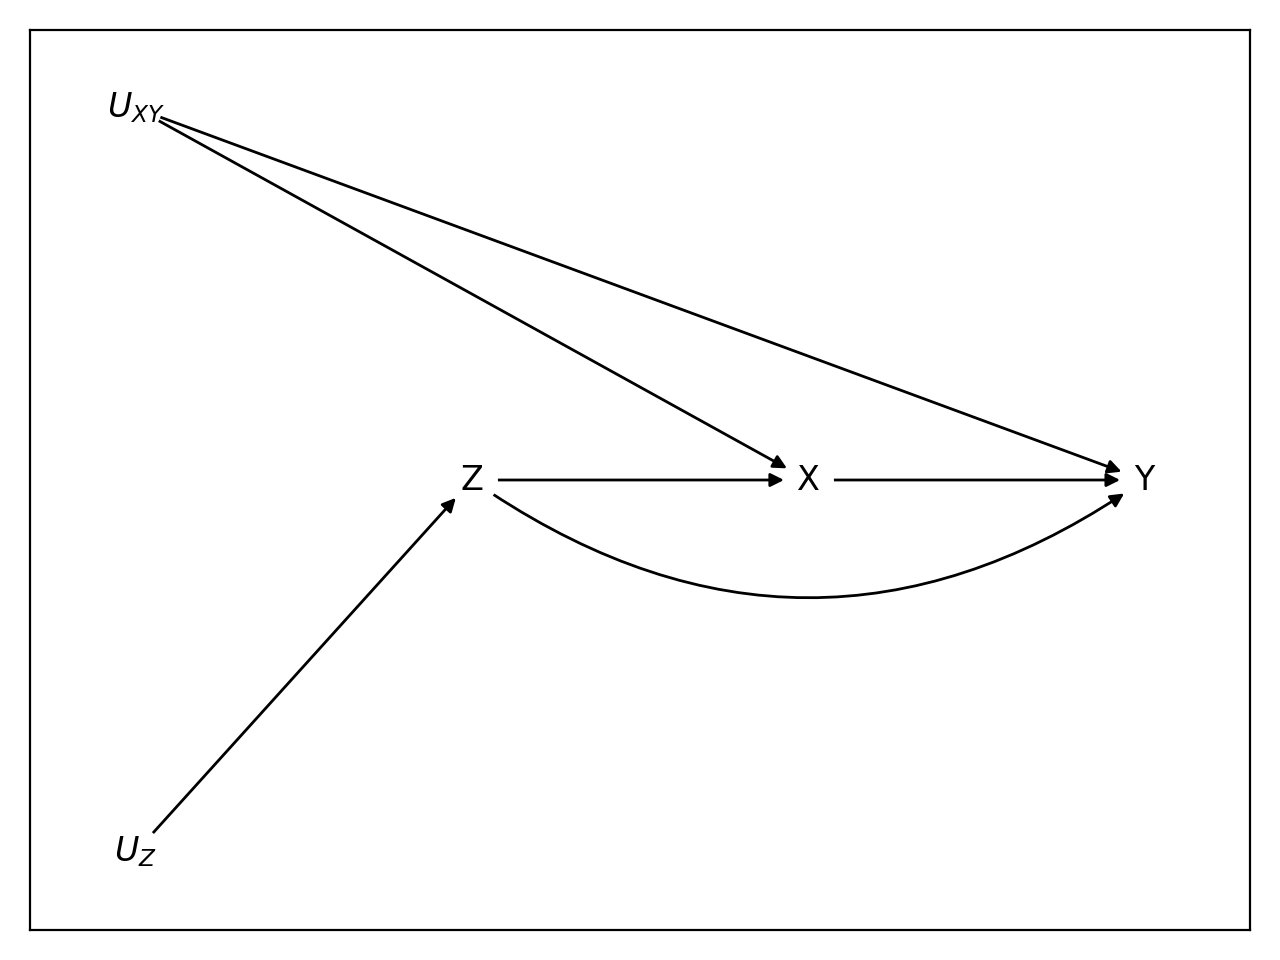

In [61]:
dag_cautious = DAG()
dag_cautious.from_structure(edges="Uz -> Z, Z -> X, Z -> Y, X -> Y, Uxy -> X, Uxy -> Y", unob = "Uz, Uxy")
dag_cautious.plot()

We then proceed as we did with Scholar Just, since all else remains unchanged.

In [18]:
problem_cautious = causalProblem(dag_cautious) # instantiate the causal problem
problem_cautious.load_data(dat) # load the empirical data
problem_cautious.add_prob_constraints() # add the Kolmogorov and emiprical constraints
problem_cautious.set_ate(ind='X', dep='Y') # construct the causal estimand

cautious_prog_ate = problem_cautious.write_program() # write the polynomial program
cautious_prog_ate.run_scip(filename='replication_files/results/iv_ate_cautious.csv') # run the optimisation routine

LOWER BOUND: # -- Primal: -0.627 / Dual: -0.627 / Time: * 0.1 ##
UPPER BOUND: # -- Primal: 0.373 / Dual: 0.373 / Time: * 0.1 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 1.0 / Epsilon: 0.0 ##


({'primal': -0.627, 'dual': -0.627, 'time': 0.13, 'end': 1},
 {'primal': 0.373, 'dual': 0.373, 'time': 0.14, 'end': 1},
 1.0,
 0.0)

Scholar Cautious determines that the average treatment effect $\tau \in [-0.627, 0.373]$. Therefore, Scholar Cautoius can **not** conlude with any confidence that there is a causal effect of $X$ on $Y$. Autobounds reflects Scholar Cautious' lack of faith ($Z \rightarrow Y$) in the IV assumptions by revealing a significantly wider bound on the causal effect. 

### 3.1.3 Scholar Confident

* Scholar Confident agrees with Scholar Just in terms of the data generating process, however, is overly confident in their assumptions on the individual behaviour of subjects in the study. In particular, they believe that the "no defiers" assumption holds, which we remark would permit us to point identify the local average treament effect in the compliers (see later). We can restate this assumption as a probabilisitc statement. The absence of defiers is equivalent to
\begin{equation}
    \mathbb{P}(D(z=1)=0, D(z=0)=1)) = 0.
\end{equation}
We can tell `autobounds` to impose this assumption as a constraint on the optimisation problem it solves.

    Indeed, Scholar Confident and Scholar Just agree on the constraint sets $\mathcal{C}_\mathcal{P}$ and $\mathcal{C}_\mathcal{E}$. However, we must also add a constraint on the problem in the form of Scholar Confident's further assumption on the behavioural makeup of the group. We may write (as this condition does not depend on the disturbance $U_Z$)
    \begin{equation}
        \mathbb{P}(D(z=1)=0, D(z=0)=1)) = \sum_{u_{XY} \in \widehat{U} } \Puxy,
    \end{equation}
    where
    \begin{equation}
        \widehat{U} = \left\{ \uin{XY} : f_D^{(U_{XY} = u_{XY})} (z=1) = 0, f_D^{(U_{XY} = u_{XY})} (z=0) = 1 \right\}.
    \end{equation}
    Thus, we have that 
    \begin{equation}
    \mathcal{C}_{\mathcal{A}} = \left\{ \sum_{u_{XY} \in \widehat{U} } \Puxy = 0\right\}
    \end{equation}

We now proceed to implement this in the `autobounds` package. The code setup is very similar to that of Scholar Just's analysis, however we must add this further assumption $\mathcal{A}$ to Scholar Confident's problem. 

In [19]:
problem_confident = causalProblem(dag_just) # initialise causal problem

Let us now add the monotonicity constraint to the problem. To do this, we first must tell the causal problem of the type of constraint we wish to add via the `query` method, following which the `add_constraint` method will augment the causal problem with this query. The `query` method takes the argument `expr` takes a character expression for the counterfactual event of interest, and the argument `sign` which takes one of the integers $\pm 1$ to denote the sign of the query (this is useful when you have a difference of probabilities). 

The syntax required for the `expr` argument is very intuitive and matches the mathematical description used in this document. 

In [20]:
q = problem_confident.query(expr='X(Z=0)=1&X(Z=1)=0', sign=1) # create the probability object of this counterfactual event, positive sign
problem_confident.add_constraint(q) # adding the monotonicity constraint to the problem

We then proceed as before, with the slight modification that Autobounds now solves
\begin{equation}
\text{min}\; \tau \; \text{subject to} \; \mathcal{C}_\mathcal{E} \cap \mathcal{C}_\mathcal{P} \cap \mathcal{C}_\mathcal{A}
\end{equation}
and
\begin{equation}
\text{max}\; \tau \; \text{subject to} \; \mathcal{C}_\mathcal{E} \cap \mathcal{C}_\mathcal{P} \cap \mathcal{C}_\mathcal{A}
\end{equation}

In [21]:
problem_confident.load_data(dat)
problem_confident.add_prob_constraints()
problem_confident.set_ate(ind='X', dep='Y')
confident_prog_ate = problem_confident.write_program()
confident_prog_ate.run_scip(filename='replication_files/results/iv_ate_overconfident') 

Problem is infeasible. Returning without solutions
Problem is infeasible. Returning without solutions


({'end': 0}, {'end': 0}, -1, -1)

At the end of this analysis, we find that Scholar Confident cannot elicit any information from their set up: Autobounds returns the problem as infeasible. This implies that there is some conflict between the assumptions of the model and the data generating process. 

It is well known that the causal IV graph implies some inequality constraints on the factual distributions of the variables conditional on the instrument. Most generally, they take the form
\begin{equation}
\max_{x} \sum_y \max_z \left[\Pro(X=x, Y=y | Z=z)\right] \le 1.
\end{equation}
However, since the problem proposed by Scholar Just was feasible, and that of Scholar Cautious had even weaker assumptions, this result suggests that the "no defiers" assumption is too strong for this analysis (although this is directly untestable.) Scholar Confident may henceforth wish to reexamine their beliefs in another attempt at this analysis. 

## 3.2 The LATE

Suppose now that is of interest to each Scholar to compute the local average treatment effect (LATE) in the compliers. No Scholar has changed their beliefs or assumptions about the data generating process or external assumptions. Mathematically, this estimand takes the form
\begin{align}
\tau^* &= \E[Y(x=1) - Y(x=0) | X(z=1) = 1, X(z=0) = 0] \\
&= \Pro(Y(x=1)=1|X(z=1) = 1, X(z=0) = 0) - \Pro(Y(x=0)=1 | X(z=1) = 1, X(z=0) = 0).
\end{align}
Algebraically, slightly more work is required to establish the polynomial program, however it is no more difficult to implement in the `autobounds` package. We will instantiate the causal problem for each Scholar together and the analyse the results.

Firstly, let us copy the causal problems we intially created with all the assumptions and data loaded for each Scholar. 

In [22]:
just_late = deepcopy(problem_just) 
cautious_late = deepcopy(problem_cautious) 
confident_late = deepcopy(problem_confident) 

Notice that the LATE is an average treatment effect within a specific stratum of individuals in the study. Therefore, we use the third argument of the `set_ate` method to indicate that we wish to compute the average treatment effect in the compliers, the syntax for which we have already seen. 

In [23]:
just_late.set_ate(ind = "X",
                  dep = "Y",
                  cond = "X(Z=1)=1&X(Z=0)=0") # within the compliers 
cautious_late.set_ate(ind = "X",
                      dep = "Y",
                      cond = "X(Z=1)=1&X(Z=0)=0")
confident_late.set_ate(ind = "X",
                       dep = "Y",
                       cond = "X(Z=1)=1&X(Z=0)=0")

We now write the polynomial programs and run the optimisation routines.

In [24]:
just_prog_late = just_late.write_program()
cautious_prog_late = cautious_late.write_program()
confident_prog_late = confident_late.write_program()

**Scholar Just (LATE)**

In [25]:
just_prog_late.run_scip(filename = 'replication_files/results/iv_late_just.csv')

LOWER BOUND: # -- Primal: -0.5492334 / Dual: -0.5492693 / Time: * 0.0 ##
UPPER BOUND: # -- Primal: -0.1457122 / Dual: -0.1456953 / Time: * 0.0 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 0.403574 / Epsilon: 0.00013084814379005216 ##


({'primal': -0.549233444611903,
  'dual': -0.549233444611903,
  'time': 0.04,
  'end': 1},
 {'primal': -0.145712155380047,
  'dual': -0.145712155380047,
  'time': 0.05,
  'end': 1},
 0.40352128923185604,
 0.0)

**Scholar Cautious (LATE)**

In [26]:
cautious_prog_late.run_scip(filename = 'replication_files/results/iv_late_cautious.csv')

LOWER BOUND: # -- Primal: -0.627 / Dual: -0.627 / Time: * 0.1 ##
UPPER BOUND: # -- Primal: 0.373 / Dual: 0.373 / Time: * 0.1 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 1.0 / Epsilon: 0.0 ##


({'primal': -0.627, 'dual': -0.627, 'time': 0.12, 'end': 1},
 {'primal': 0.373, 'dual': 0.373, 'time': 0.09, 'end': 1},
 1.0,
 0.0)

**Scholar Confident (LATE)**

In [27]:
confident_prog_late.run_scip(filename = 'replication_files/results/iv_late_confident.csv')

Problem is infeasible. Returning without solutions
Problem is infeasible. Returning without solutions


({'end': 0}, {'end': 0}, -1, -1)

# References

Guilherme Duarte, Noam Finkelstein, Dean Knox, Jonathan Mummolo & Ilya Shpitser (2023) An Automated Approach to Causal Inference in Discrete Settings*, Journal of the American Statistical Association, DOI: 10.1080/01621459.2023.2216909

In [8]:
raw_iv_dat = pd.DataFrame(np.repeat(iv_dat.drop(columns=['prob'], axis=0).to_numpy(),
                                 np.round(1000*iv_dat['prob']),
                                 axis=0), 
                       columns=iv_dat.drop(columns=['prob'], axis=0).columns).sample(frac=1).reset_index().drop(columns=['index'], axis=0)

In [10]:
# some networkx code to generate some causal graph visaulisations
def iv_graph(faith):
    """
    Generate a visualisation of a causal IV graph according to
    the degree of faith in the causal mechanism

        Arguments:
            faith (str): one of {"just", "cautious"}
            
        Returns:
            G (DiGraph): a directed graph visualising the causal mechanism
            labels (set): labels of nodes in the graph
            pos (dict): node positions
    """

    G = nx.DiGraph(with_labels=False)
    G.add_node(0,label=r"$U_Z$", pos=(-1,0.007))
    G.add_node(1,label=r"$Z$", pos=(-1,-0.002))
    G.add_node(2,label=r"$X$", pos=(0,0))
    G.add_node(3,label=r"$U_{XY}$", pos=(1,0.007))
    G.add_node(4,label=r"$Y$", pos=(2,0))

    G.add_edges_from([(0,1), (1,2), (3,2), (3,4), (2,4)])
    labels = {node:G.nodes[node]['label'] for node in G.nodes()}
    pos=nx.get_node_attributes(G,'pos')

    if faith == "just":
        return G, labels, pos
    elif faith == "cautious":
        G.add_edge(1,4, rad=0.4)
        return G, labels, pos


plt.figure(figsize=(4,4))
just_iv, labels, pos = iv_graph(faith="just")
nx.draw(just_iv, labels=labels, with_labels=True, pos=pos, node_color="white")

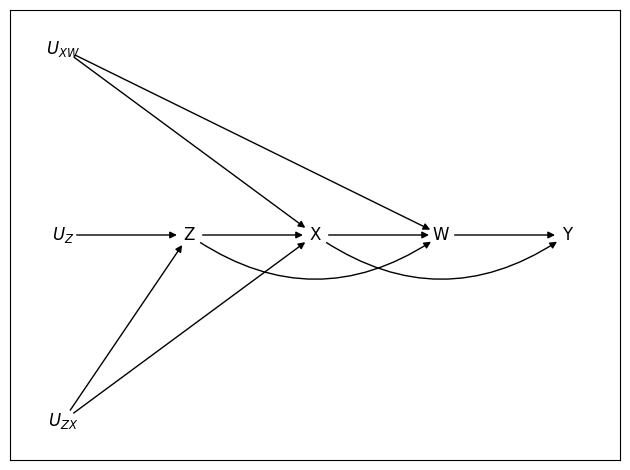

In [7]:
dag_play = DAG()
dag_play.from_structure("Uzx -> Z, Uzx -> X, Uz -> Z, X -> W, W -> Y, X -> Y, Z -> W, Z -> X, Uxw -> X, Uxw -> W", unob = "Uzx, Uw, Uxw")
dag_play.plot()

In [59]:
# questionable outcomes ... and deepcopy I don't think works properly

just_late = causalProblem(dag_just)
just_late.load_data(dat)
just_late.add_prob_constraints()
just_late.add_constraint(just_late.query("X(Z=1)=1&X(Z=0)=0") - Query(0.0001), ">=")
just_late.set_ate(ind = "X",
                  dep = "Y",
                  cond = "X(Z=1)=1&X(Z=0)=0") # within the compliers 
just_prog_late = just_late.write_program()
just_prog_late.run_scip(filename = 'replication_files/results/iv_late_just.csv')

LOWER BOUND: # -- Primal: -1.00637 / Dual: -1.00637 / Time: * 0.1 ##
UPPER BOUND: # -- Primal: 1.009324 / Dual: 1.009324 / Time: * 0.0 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 2.015694 / Epsilon: 0.0 ##


({'primal': -1.0063702985382,
  'dual': -1.0063702985382,
  'time': 0.05,
  'end': 1},
 {'primal': 1.00932374112062,
  'dual': 1.00932374112062,
  'time': 0.05,
  'end': 1},
 2.01569403965882,
 0.0)

In [63]:
cautious_late = causalProblem(dag_cautious)
cautious_late.load_data(dat)
cautious_late.add_prob_constraints()
cautious_late.add_constraint(cautious_late.query("X(Z=1)=1&X(Z=0)=0") - Query(0.0001), ">=")
cautious_late.set_ate(ind = "X",
                      dep = "Y",
                      cond = "X(Z=1)=1&X(Z=0)=0")
cautious_prog_late = cautious_late.write_program()
cautious_prog_late.run_scip(filename = 'replication_files/results/iv_late_cautious.csv')

LOWER BOUND: # -- Primal: -- / Dual: -342175.9 / Time: 0.5 ##
UPPER BOUND: # -- Primal: -- / Dual: 311778.1 / Time: 0.5 ##


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [64]:
confident_late = causalProblem(dag_just)
confident_late.load_data(dat)
confident_late.add_prob_constraints()
q_late = confident_late.query(expr='X(Z=0)=1&X(Z=1)=0', sign=1)
confident_late.add_constraint(confident_late.query("X(Z=1)=1&X(Z=0)=0") - Query(0.0001), ">=")
confident_late.add_constraint(q_late) # adding the monotonicity constraint to the problem
confident_late.set_ate(ind = "X",
                      dep = "Y",
                      cond = "X(Z=1)=1&X(Z=0)=0")



confident_prog_late = confident_late.write_program()



confident_prog_late.run_scip(filename = 'replication_files/results/iv_late_confident.csv')

LOWER BOUND: # -- Primal: -- / Dual: -298144.1 / Time: 34.4 ##
UPPER BOUND: # -- Primal: -- / Dual: 305202.0 / Time: 34.5 ##
Problem is infeasible. Returning without solutions
Problem is infeasible. Returning without solutions


TypeError: unsupported operand type(s) for -: 'str' and 'str'